# <center>Курсовой проект<center>

## Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета:**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

## Загрузка библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
matplotlib.rcParams.update({'font.size': 12})

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb

import pickle

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100
pd.options.display.max_rows = 30

**Функции для анализа качества модели**

In [2]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [3]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.3, 0.7, 41):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

## Загрузка и анализ данных

In [4]:
data_train = pd.read_csv('course_project_train.csv')
data_test = pd.read_csv('course_project_test.csv')
data_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
data_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
for feat in data_train.columns:
    print(data_train[feat].value_counts())
    print(30 * '*')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
******************************
1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
******************************
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
******************************
0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
******************************
9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
       ... 
42.0      1
43.0      1
35.0      1
38.0      1
41.0      1
Name: Number of Open Accounts, Length: 39, 

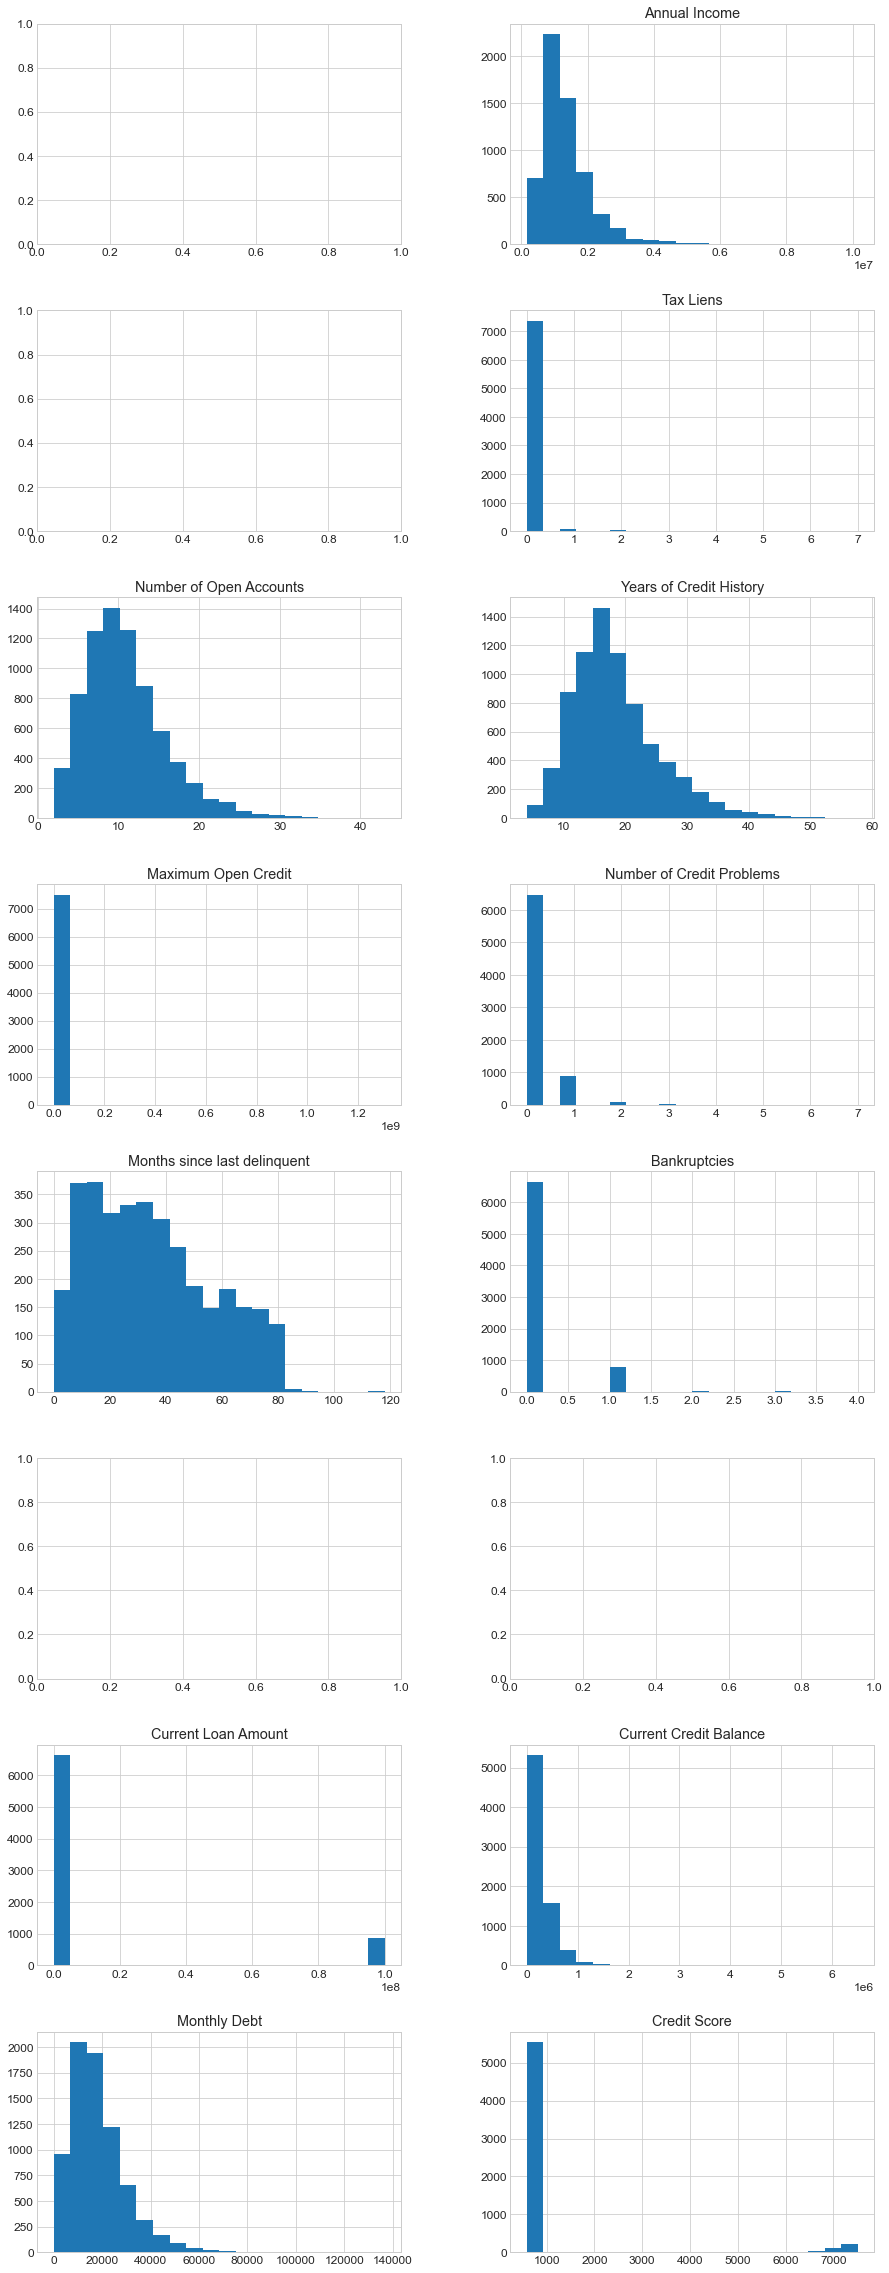

In [8]:
fig, ax = plt.subplots(8, 2)
ax = ax.flatten()

fig.set_size_inches(15, 41)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(16):
    if i not in [0, 2, 10, 11]:
        ax[i].hist(data_train.iloc[:, i], bins=20)
        ax[i].set_title(data_train.columns[i])

<AxesSubplot:>

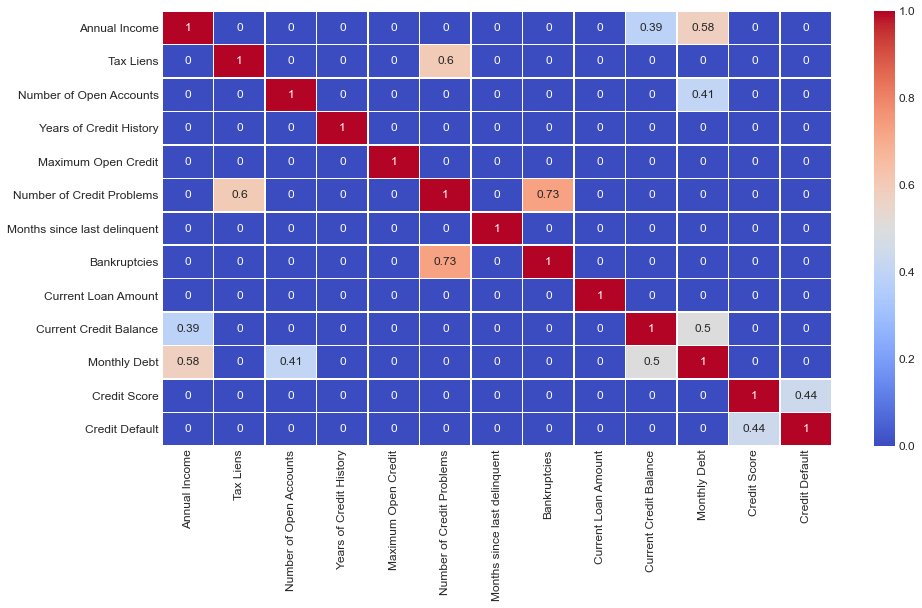

In [9]:
data_corr = np.round(data_train.corr(), 2)
data_corr[np.abs(data_corr) < 0.3] = 0

plt.figure(figsize=(15, 8))
sns.heatmap(data_corr, annot=True, linewidths=.5, cmap='coolwarm')

(0.0, 60000.0)

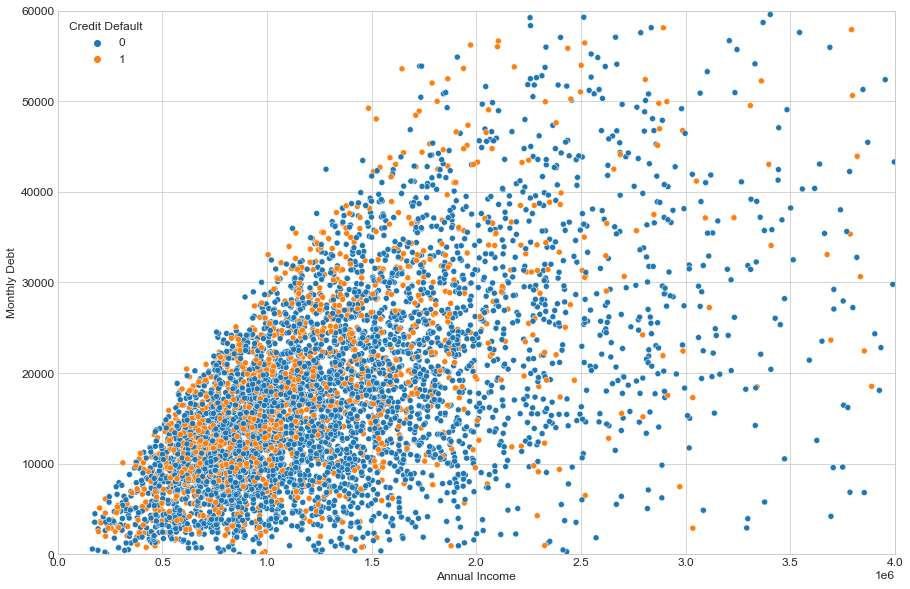

In [10]:
f, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=data_train, x='Annual Income', y='Monthly Debt', hue='Credit Default')

ax.set_xlim([0, 4000000])
ax.set_ylim([0, 60000])

(0.0, 4000000.0)

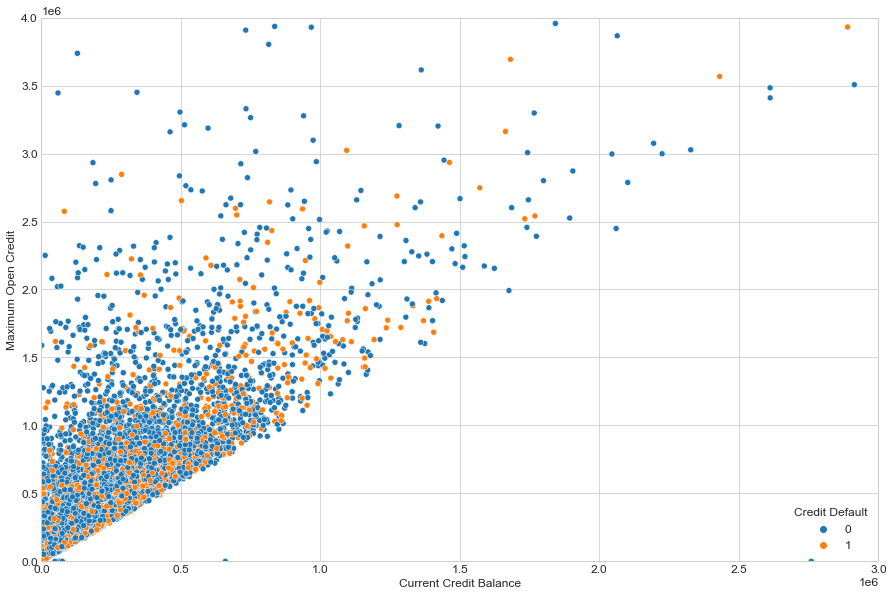

In [11]:
f, ax = plt.subplots(figsize=(15, 10))

sns.scatterplot(data=data_train, x='Current Credit Balance', y='Maximum Open Credit', hue='Credit Default')

ax.set_xlim([0, 3000000])
ax.set_ylim([0, 4000000])

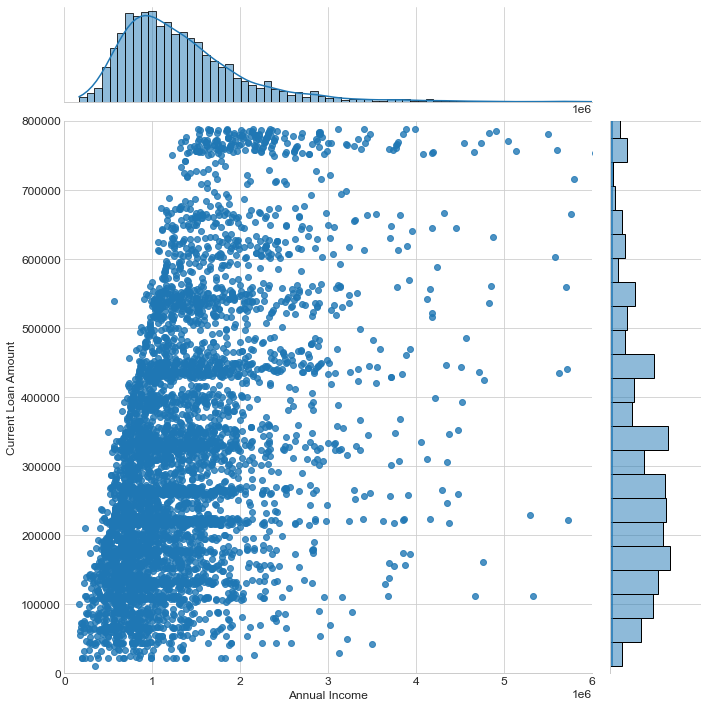

In [12]:
g = sns.jointplot(data=data_train, x='Annual Income', y='Current Loan Amount',
                  kind="reg", xlim=(0, 6000000), ylim=(0, 800000), height=10)

## Обработка пропусков и выбросов, генерация признаков.

Изучив датасет, создадим функцию для обработки пропусков и выбросов, генерации признаков на основе найденных зависимостей.

In [13]:
def prepared_data(data):
    df = data.copy()
    
    # Создадим dummy-признаки на основе категориального признака Home Ownership, обработав перед этим редкие значения.
    df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'
    df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
    
    # На основе некоторой зависимости c Monthly Debt заполним пропуски значений Annual Income.
    df['Annual_Income_isna'] = df['Annual Income'].isna().astype('int')
    df['Annual Income'] = df['Annual Income'].fillna(df['Monthly Debt'] * 60)
    
    # Также создадим признаки, отображающте ежемесячный остаток денежных средств и категорию годового дохода.
    df['Cash_Balance'] = (df['Annual Income'] / 12 - df['Monthly Debt']).astype('int')
    df['Annual_Income_cat'] = pd.qcut(df['Annual Income'], q=5, labels=False)
    
    # Заполним пропуски Years in current job и несколько преобразуем, оставив только 4 категории.
    cat_year_map = {'< 1 year': 0, '1 year': 0, '2 years': 1, '3 years': 1, '4 years': 1, '5 years': 2,
                    '6 years': 2, '7 years': 2, '8 years': 2, '9 years': 2, '10+ years': 3}
    df['Years_in_current_job_isna'] = df['Years in current job'].isna().astype('int')
    df['Years in current job'] = df['Years in current job'].fillna('< 1 year')
    df['Years_in_current_job_cat'] = df['Years in current job'].map(cat_year_map).astype('int')
    
    # Создадим бинарные признаки на основе самым популярных значений признаков:
    # Tax Liens, Number of Credit Problems, Bankruptcies(заполнив пропуски), Purpose.
    df['Has_Tax_Liens'] = (df['Tax Liens'] > 0).astype('int')
    df['Has_Credit_Problems'] = (df['Number of Credit Problems'] > 0).astype('int')
    df['Bankruptcies'] = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0])
    df['Has_Bankruptcies'] = (df['Bankruptcies'] > 0).astype('int')
    df['Purpose_is_debt_consolidation'] = (df['Purpose'] == 'debt consolidation').astype('int')
    
    # Также закроем выбросы фичи Maximum Open Credit, исходя из некоторой зависимости с Current Credit Balance.
    df.loc[(df['Maximum Open Credit'] > 30000000) | (df['Maximum Open Credit'] == 0), 'Maximum Open Credit'] = \
        2 * df.loc[(df['Maximum Open Credit'] > 30000000) | (df['Maximum Open Credit'] == 0), 'Current Credit Balance']
    
    # Удалим признак Months since last delinquent
    df = df.drop(columns='Months since last delinquent')
    
    # Создадим dummy-переменные для категориального признака Term
    df = pd.concat([df, pd.get_dummies(df['Term'])], axis=1)
    
    # Заменим значения выбросов Current Loan Amount на медианы значений, 
    # сгруппированных по признакам Annual Income cat и Term.
    gb_cla = df.groupby(['Annual_Income_cat', 'Term'], as_index=False)['Current Loan Amount'].\
        median().rename(columns={'Current Loan Amount': 'Med_Loan_Amount'})
    df = df.merge(gb_cla, on=['Annual_Income_cat', 'Term'], how='left')
    df['Med_Loan_Amount'] = df['Med_Loan_Amount'].astype('int')

    df['Current_Loan_Amount_outlier'] = (df['Current Loan Amount'] == 99999999).astype('int')
    df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = \
        df.loc[df['Current Loan Amount'] == 99999999, 'Med_Loan_Amount']
    
    # Обработаем выбросы Credit Score, а пропуски заменим на медианы значений,
    # сгруппированных по признакам Term, Has_Credit_Problems, Home Mortgage
    df.loc[df['Credit Score'] > 3000, 'Credit Score'] /= 10

    gb_cs = df.groupby(['Term', 'Has_Credit_Problems', 'Home Mortgage'], as_index=False)['Credit Score'].\
        median().rename(columns={'Credit Score': 'Med_Credit_Score'})
    df = df.merge(gb_cs, on=['Term', 'Has_Credit_Problems', 'Home Mortgage'], how='left')
    df['Med_Credit_Score'] = df['Med_Credit_Score'].astype('int')

    df['Credit Score'] = df['Credit Score'].fillna(df['Med_Credit_Score'])
    
    # Также добавим каждому обьекту ID
    df['ID'] = df.index.tolist()
    
    return df

In [14]:
prep_train = prepared_data(data_train)
prep_test = prepared_data(data_test)
prep_train.to_csv('prepared_data_train.csv', index=False)
prep_test.to_csv('prepared_data_test.csv', index=False)

prep_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Mortgage,Own Home,Rent,Annual_Income_isna,Cash_Balance,Annual_Income_cat,Years_in_current_job_isna,Years_in_current_job_cat,Has_Tax_Liens,Has_Credit_Problems,Has_Bankruptcies,Purpose_is_debt_consolidation,Long Term,Short Term,Med_Loan_Amount,Current_Loan_Amount_outlier,Med_Credit_Score,ID
0,Rent,408780.0,4 years,0.0,9.0,12.5,220968.0,0.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,731.0,0,0,1,1,27252,0,0,1,0,0,0,1,0,1,174845,0,731,0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0,0,1,0,17001,0,0,0,0,0,0,0,0,1,174845,0,731,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,1,0,0,0,77316,2,0,1,0,0,0,1,0,1,287936,0,739,2
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,1,0,0,0,74133,2,0,3,0,0,0,1,0,1,287936,0,739,3
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,1,0,0,0,152474,4,0,2,0,0,0,1,1,0,601656,0,708,4


In [15]:
prep_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Home Ownership                 2500 non-null   object 
 1   Annual Income                  2500 non-null   float64
 2   Years in current job           2500 non-null   object 
 3   Tax Liens                      2500 non-null   float64
 4   Number of Open Accounts        2500 non-null   float64
 5   Years of Credit History        2500 non-null   float64
 6   Maximum Open Credit            2500 non-null   float64
 7   Number of Credit Problems      2500 non-null   float64
 8   Bankruptcies                   2500 non-null   float64
 9   Purpose                        2500 non-null   object 
 10  Term                           2500 non-null   object 
 11  Current Loan Amount            2500 non-null   float64
 12  Current Credit Balance         2500 non-null   f

In [16]:
prep_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Home Mortgage,Own Home,Rent,Annual_Income_isna,Cash_Balance,Annual_Income_cat,Years_in_current_job_isna,Years_in_current_job_cat,Has_Tax_Liens,Has_Credit_Problems,Has_Bankruptcies,Purpose_is_debt_consolidation,Long Term,Short Term,Med_Loan_Amount,Current_Loan_Amount_outlier,Med_Credit_Score,ID
count,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000
mean,1.312973e+06,0.035200,11.184400,18.325920,6.929682e+05,0.162000,0.106800,315010.084400,2.963966e+05,18271.340000,721.087200,0.492800,0.09920,0.408000,0.205200,9.114275e+04,2.000000,0.034400,1.730400,0.022000,0.129200,0.098000,0.789200,0.255600,0.744400,328894.341600,0.118800,725.654000,1249.50000
std,8.780382e+05,0.386291,4.852774,7.254659,1.079723e+06,0.559894,0.356994,176144.507961,3.783020e+05,11543.881469,25.597408,0.500048,0.29899,0.491561,0.403928,6.726541e+04,1.414496,0.182291,1.096447,0.146713,0.335488,0.297374,0.407958,0.436285,0.436285,121635.827144,0.323618,14.180138,721.83216
min,5.820000e+03,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,15422.000000,0.000000e+00,93.000000,585.000000,0.000000,0.00000,0.000000,0.000000,3.880000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,174845.000000,0.000000,695.000000,0.00000
25%,8.071328e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,0.000000,177034.000000,1.101145e+05,10024.750000,708.000000,0.000000,0.00000,0.000000,0.000000,5.428075e+04,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,235092.000000,0.000000,708.000000,624.75000
50%,1.156701e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,0.000000,287936.000000,2.073850e+05,16642.500000,730.000000,0.000000,0.00000,0.000000,0.000000,7.765900e+04,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,319297.000000,0.000000,731.000000,1249.50000
75%,1.604024e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,0.000000,433086.500000,3.663485e+05,24146.000000,739.000000,1.000000,0.00000,1.000000,0.000000,1.112530e+05,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,449328.000000,0.000000,739.000000,1874.25000
max,1.497561e+07,15.000000,48.000000,53.400000,2.606996e+07,15.000000,5.000000,789096.000000,6.030087e+06,93555.000000,751.000000,1.000000,1.00000,1.000000,1.000000,1.244598e+06,4.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,601656.000000,1.000000,739.000000,2499.00000


## Отбор признаков и построение модели

In [17]:
learning_features = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Current Loan Amount', 'Current Credit Balance',
                     'Monthly Debt', 'Credit Score', 'Home Mortgage', 'Own Home', 'Rent',
                     'Annual_Income_isna', 'Cash_Balance', 'Annual_Income_cat',
                     'Years_in_current_job_isna', 'Years_in_current_job_cat',
                     'Has_Tax_Liens', 'Has_Credit_Problems', 'Has_Bankruptcies',
                     'Purpose_is_debt_consolidation', 'Long Term', 'Short Term',
                     'Med_Loan_Amount', 'Current_Loan_Amount_outlier', 'Med_Credit_Score']
target_feature = 'Credit Default'

In [18]:
X = prep_train[learning_features]
y = prep_train[target_feature]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.3, random_state=23)

Проанализировав многие модели с помощью GridSearchCV, лучшей оказалась CatBoost.

In [19]:
final_model = catb.CatBoostClassifier(class_weights=[1, 3], n_estimators=200, max_depth=3, 
                                          learning_rate=0.1, random_state=23, silent=True)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_valid_pred = final_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.58      0.71      3771
           1       0.45      0.87      0.59      1479

    accuracy                           0.66      5250
   macro avg       0.68      0.72      0.65      5250
weighted avg       0.78      0.66      0.67      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.53      0.65      1616
           1       0.39      0.76      0.52       634

    accuracy                           0.60      2250
   macro avg       0.62      0.65      0.59      2250
weighted avg       0.72      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               860  756
1               151  483


In [20]:
cross_val_score(final_model, X, y, cv=5, scoring='f1')

array([0.52830189, 0.51008878, 0.53864169, 0.5150079 , 0.496875  ])

Дополнительно проанализировав метрики в зависимости от порогов вероятностей принадлежности к основному классу, выберем порог, соответствующей максимуму f1.

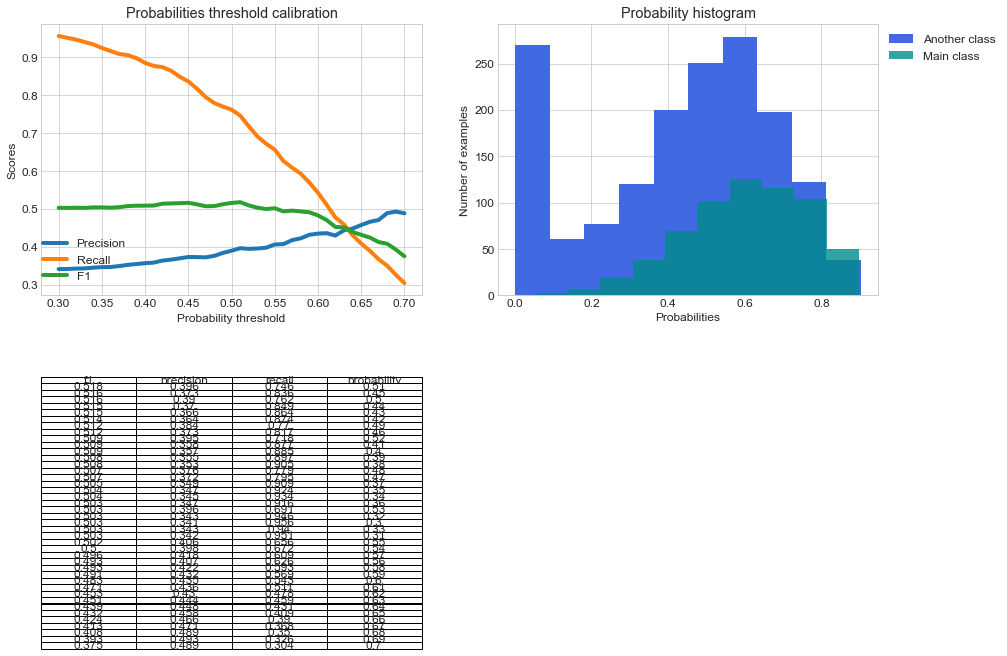

In [21]:
y_train_pred_proba = final_model.predict(X_train, prediction_type='Probability')
y_valid_pred_proba = final_model.predict(X_valid, prediction_type='Probability')

show_proba_calibration_plots(y_valid_pred_proba[:, 1], y_valid)

In [22]:
y_train_pred = np.where(y_train_pred_proba[:, 1] > 0.51, 1, 0)
y_valid_pred = np.where(y_valid_pred_proba[:, 1] > 0.51, 1, 0)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.60      0.72      3771
           1       0.45      0.84      0.59      1479

    accuracy                           0.67      5250
   macro avg       0.68      0.72      0.65      5250
weighted avg       0.78      0.67      0.68      5250

TEST

              precision    recall  f1-score   support

           0       0.85      0.55      0.67      1616
           1       0.40      0.75      0.52       634

    accuracy                           0.61      2250
   macro avg       0.62      0.65      0.59      2250
weighted avg       0.72      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               896  720
1               161  473


## Предсказание на тестовом датасете

In [23]:
X_test = prep_test[learning_features]
y_test_pred_proba = final_model.predict(X_test, prediction_type='Probability')
y_test_pred = np.where(y_test_pred_proba[:, 1] > 0.51, 1, 0)

In [24]:
pd.DataFrame(y_test_pred, columns=['Credit Default']).reset_index().rename(columns={'index': 'ID'})\
    .to_csv('INevskiy_predictions.csv', index=False)